Библиотеки:

In [ ]:
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import string
from spacy.lang.en import English
import nltk
from spacy.matcher import Matcher
from spacy.tokens import Span
from tqdm import tqdm
import bs4
import requests
from spacy import displacy
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Извлечение именных сущностей из предложений


In [ ]:
def get_entities(sentence):
    entity1 = ""
    entity2 = ""

    previous_token_dependency = ""
    previous_token_text = ""

    prefix = ""
    modifier = ""

    for token in nlp(sentence):
        if token.dep_ != "punct":
            if token.dep_ == "compound":
                prefix = token.text
                if previous_token_dependency == "compound":
                    prefix = previous_token_text + " " + token.text
            if token.dep_.endswith("mod") == True:
                modifier = token.text
                if previous_token_dependency == "compound":
                    modifier = previous_token_text + " " + token.text
            if token.dep_.find("subj") == True:
                entity1 = modifier + " " + prefix + " " + token.text
                prefix = ""
                modifier = ""
                previous_token_dependency = ""
                previous_token_text = ""
            if token.dep_.find("obj") == True:
                entity2 = modifier + " " + prefix + " " + token.text
            previous_token_dependency = token.dep_
            previous_token_text = token.text

    return [entity1.strip(), entity2.strip()]

Очистка текста от цифр, удаление ссылок, удаление пунктуации

In [ ]:
def clean_text(x):
    text = re.sub('(\d+)','',x)
    text = text.lower()
    return text

In [ ]:
def remove_url(x):
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})\/([a-zA-Z0-9_]+]*)',' ',x)
    return text

In [ ]:
def remove_punct(x):
    text_without_puct = [t for t in x if t not in string.punctuation]
    text_without_puct = ''.join(text_without_puct)
    return text_without_puct

Стоп слова

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
stop = stopwords.words('english')

Извлечение отношений между сущностяями и предложениями

In [ ]:
def get_relation(sentence):
    doc = nlp(sentence)

    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern])

    matches = matcher(doc)

    last_match_index = len(matches) - 1
    span = doc[matches[last_match_index][1]:matches[last_match_index][2]]

    return span.text

Датасет:

In [ ]:
import pandas as pd
df = pd.read_csv('Text based Religion Posts 35000.csv')
df

,index,Document,subreddit
0,527941,"I was raised as a Muslim, but never got into t...",islam
1,534235,"\nAs salamu alaikum, I wonder what the benefit...",islam
2,531104,I was at a coffee shop when I saw a carbonara ...,islam
3,525922,"Hello, so I am a 13 year old boy, naturally I ...",islam
4,523640,We intend to get married soon but my father an...,islam
...,...,...,...
34995,24397,"You never hear of the Lord Shiva, for example,...",hinduism
34996,23344,**Question 1 : What is the difference between ...,hinduism
34997,23076,"The symbol right now is associated with hate, ...",hinduism
34998,25367,\n\nNamaste dear all \n \n\nI am really rea...,hinduism


In [ ]:
df.shape

(35000, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      35000 non-null  int64 
 1   Document   35000 non-null  object
 2   subreddit  35000 non-null  object
dtypes: int64(1), object(2)
memory usage: 820.4+ KB


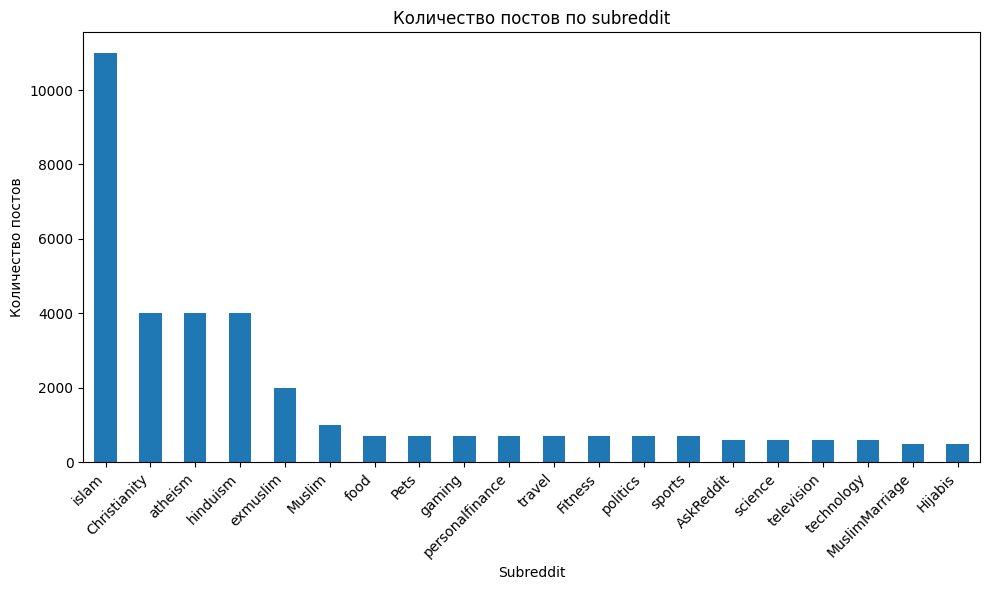

In [ ]:
subreddit_counts = df['subreddit'].value_counts()

plt.figure(figsize=(10, 6))
subreddit_counts.plot(kind='bar')
plt.title('Количество постов по subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Количество постов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

index        0
Document     0
subreddit    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
isl = df[df['subreddit'] == 'islam']
chris = df[df['subreddit'] == 'Christianity']
hindu = df[df['subreddit'] == 'atheism']
new_df = pd.concat([isl, chris, hindu], ignore_index=True)

In [ ]:
isl.head(5)

,index,Document,subreddit
0,527941,"I was raised as a Muslim, but never got into t...",islam
1,534235,"\nAs salamu alaikum, I wonder what the benefit...",islam
2,531104,I was at a coffee shop when I saw a carbonara ...,islam
3,525922,"Hello, so I am a 13 year old boy, naturally I ...",islam
4,523640,We intend to get married soon but my father an...,islam


In [ ]:
chris.head(5)

,index,Document,subreddit
23000,454588,I have not been to church for well over 10 yea...,Christianity
23001,426539,"Hey, Christianity! I found this subreddit a wh...",Christianity
23002,435291,I was wondering....there are a lot of question...,Christianity
23003,442299,"As an atheist, I am always told about the ""evi...",Christianity
23004,431242,http://i.imgur.com/Y4FfqLO.jpg\nThis is my bes...,Christianity


In [ ]:
hindu.head(5)

,index,Document,subreddit
27000,233780,"As a Christian, I'm all for Atheists pointing ...",atheism
27001,221626,I started when I was 8. My grandmother was rel...,atheism
27002,233312,A while back (by which I mean a year ago) in b...,atheism
27003,235503,"I understand when people put really offensive,...",atheism
27004,235420,I am a Atheist. I have been very against organ...,atheism


In [ ]:
new_df

,index,Document,subreddit
0,527941,"I was raised as a Muslim, but never got into t...",islam
1,534235,"\nAs salamu alaikum, I wonder what the benefit...",islam
2,531104,I was at a coffee shop when I saw a carbonara ...,islam
3,525922,"Hello, so I am a 13 year old boy, naturally I ...",islam
4,523640,We intend to get married soon but my father an...,islam
...,...,...,...
295,233290,It is just another piece of paper.\n\nConstitu...,atheism
296,230318,It's finally happened! My mother (the crazy fu...,atheism
297,249230,"Alright, so visited the vatican, and i noticed...",atheism
298,250668,It seems to me that thanking God for all the g...,atheism


In [ ]:
y = new_df.pop('subreddit')
new_df = new_df.drop('index' , axis = 1)

In [ ]:
y

0          islam
1          islam
2          islam
3          islam
4          islam
          ...   
18995    atheism
18996    atheism
18997    atheism
18998    atheism
18999    atheism
Name: subreddit, Length: 19000, dtype: object

In [ ]:
new_df

,Document
0,"I was raised as a Muslim, but never got into t..."
1,"\nAs salamu alaikum, I wonder what the benefit..."
2,I was at a coffee shop when I saw a carbonara ...
3,"Hello, so I am a 13 year old boy, naturally I ..."
4,We intend to get married soon but my father an...
...,...
18995,"&gt;You think you can define me, motherfucker?..."
18996,"Let's accept, for the sake of argument, that y..."
18997,"The way these scheduled readings jump around, ..."
18998,Why are so many people here friends with peopl...


In [ ]:
new_df['Document'] = new_df['Document'].apply(clean_text)
new_df['Document'] = new_df['Document'].apply(remove_url)
new_df['Document'] = new_df['Document'].apply(remove_punct)
new_df['Document'] = new_df['Document'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
new_df

,Document
0,raised muslim never got habit praying five tim...
1,salamu alaikum wonder benefits umrah hajj peop...
2,coffee shop saw carbonara pasta asked pork cas...
3,hello year old boy naturally sexual desires le...
4,intend get married soon father live great dist...
...,...
18995,gtyou think define motherfucker gtyou think pi...
18996,lets accept sake argument correct jesus return...
18997,way scheduled readings jump around rather sugg...
18998,many people friends people apparently fundamen...


In [ ]:
entity_pairs = []

for i in tqdm(new_df["Document"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 19000/19000 [07:46<00:00, 40.71it/s]


In [ ]:
entity_pairs

[['helpless salah build days', 'mindful salah build stuff'],
 ['prepared hajj thanks that', 'prepared hajj thanks contributions'],
 ['anyway  thoughts', 'sick  eating'],
 ['see doctor saudi arabia', 'probably halal way'],
 ['islamic  law', 'current person circumstances'],
 ['ashamed allah i', 'nature jazak'],
 ['beautiful  religion', 'strange  disrespectful'],
 ['terrorist army god', 'armyofgodusa hutaree'],
 ['anbiyā āyat animals', 'goto heaven'],
 ['i', 'specific  recipes'],
 ['many  muslims', 'question advice'],
 ['count i', 'count promise'],
 ['even city position', 'country'],
 ['missed payment obligations', 'help'],
 ['well efforts s', 'even efforts time'],
 ['well  knowledge', 'mindful  edit'],
 ['i d', 'side'],
 ['emotions editor', 'portray stance'],
 ['peaceful videos topic world', 'terrorism myth'],
 ['forever  ️', 'listening story'],
 ['wrong  forehead', 'totally  salam'],
 ['bigger  depth', 'major bit reason'],
 ['sincerely way antithesis', 'post'],
 ['probably  s', 'terribl

In [ ]:
relations = [get_relation(i) for i in tqdm(new_df['Document'])]

100%|██████████| 19000/19000 [07:25<00:00, 42.69it/s]


In [ ]:
relations

['came',
 'save',
 'saw',
 'handle',
 'married',
 'take',
 '’s',
 'grew christian',
 '’s',
 'bring',
 'decided deactivate',
 'help',
 'sit',
 'thank',
 'paraphrased',
 'know',
 'hear',
 'say',
 'goodintentioned',
 'gets',
 'said',
 'stood proud',
 'write short',
 'saw',
 'adopted according',
 'say',
 'said',
 '’m nervous',
 'abandons',
 'prohibited',
 'seems',
 'teach',
 'said',
 'insight relevant',
 'reported',
 'put',
 'think',
 'assalamualikum',
 'alamin',
 'decade',
 'say',
 'dude',
 'say',
 'tried',
 'felt',
 'discuss various',
 'developed',
 'looked subreddit',
 'say',
 'practice',
 'understand',
 'believes',
 'hear actual',
 'met',
 'refer little',
 'say',
 'thinks',
 'earn',
 'page',
 'guys',
 'started',
 'offend',
 'said',
 'wondering',
 'enables',
 'love',
 'lies',
 'want',
 'said',
 'like',
 'ask',
 'makes',
 'feels',
 'needs',
 'read',
 'want',
 'know bottom',
 'insist',
 'help',
 'helps',
 'do',
 'pushed',
 'posted',
 'read many',
 'said',
 'come',
 'seen obeyed',
 'made b

In [ ]:
additional_df = pd.DataFrame(entity_pairs, columns=['Subject' , 'Object'])
additional_df['relations'] = relations

In [ ]:
concatenated_df = pd.concat([new_df, additional_df], axis=1)

In [ ]:
concatenated_df.head()

,Document,Subject,Object,relations
0,raised muslim never got habit praying five tim...,helpless salah build days,mindful salah build stuff,came
1,salamu alaikum wonder benefits umrah hajj peop...,prepared hajj thanks that,prepared hajj thanks contributions,save
2,coffee shop saw carbonara pasta asked pork cas...,anyway thoughts,sick eating,saw
3,hello year old boy naturally sexual desires le...,see doctor saudi arabia,probably halal way,handle
4,intend get married soon father live great dist...,islamic law,current person circumstances,married


In [ ]:
concatenated_df.drop('Document' , inplace = True , axis = 1)

In [ ]:

G = nx.DiGraph()
for i ,row in concatenated_df.head(30).iterrows():
    G.add_edge(row['Subject'] , row['Object'] , label = row['relations'])

In [ ]:
for i ,row in concatenated_df.head(30).iterrows():
    print("Subject - ",row['Subject'] ,"||| Object -  ", row['Object'] ,"||| relations - ", row['relations'])

Subject -  helpless salah build days ||| Object -   mindful salah build stuff ||| relations -  came
Subject -  prepared hajj thanks that ||| Object -   prepared hajj thanks contributions ||| relations -  save
Subject -  anyway  thoughts ||| Object -   sick  eating ||| relations -  saw
Subject -  see doctor saudi arabia ||| Object -   probably halal way ||| relations -  handle
Subject -  islamic  law ||| Object -   current person circumstances ||| relations -  married
Subject -  ashamed allah i ||| Object -   nature jazak ||| relations -  take
Subject -  beautiful  religion ||| Object -   strange  disrespectful ||| relations -  ’s
Subject -  terrorist army god ||| Object -   armyofgodusa hutaree ||| relations -  grew christian
Subject -  anbiyā āyat animals ||| Object -   goto heaven ||| relations -  ’s
Subject -  i ||| Object -   specific  recipes ||| relations -  bring
Subject -  many  muslims ||| Object -   question advice ||| relations -  decided deactivate
Subject -  count i ||| Ob

In [ ]:

pos = nx.spring_layout(G, seed=42, k=0.9)

labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(12, 10))

nx.draw(G, pos, with_labels=True, font_size=8, node_size=500, font_color='black', font_weight='bold')

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

plt.title('Граф знаний')

plt.show()

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')

In [ ]:
G = nx.Graph()
for i ,row in concatenated_df.iterrows():
    G.add_edge(row['Subject'] , row['Object'] , label = row['relations'])

In [ ]:
pos = nx.spring_layout(G, seed=42, k=0.9)

labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(12, 10))

nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, font_color='black', font_weight='bold')

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

plt.title('Knowledge Graph')

plt.show()

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')

In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/576 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Разделение узлов на обучающий и тестовый наборы
train_nodes, test_nodes = train_test_split(list(G.nodes()), test_size=0.2, random_state=42)

# Создание признаков для узлов на основе векторных представлений
X_train = np.array([model.wv[node] for node in train_nodes])
X_test = np.array([model.wv[node] for node in test_nodes])

# Создание меток для узлов
y_train = [G.nodes[node] for node in train_nodes]
y_test = [G.nodes[node] for node in test_nodes]

# Обучение классификатора
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Предсказание меток на тестовом наборе
y_pred = classifier.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


ValueError: Unknown label type: 'unknown'

In [ ]:
node_embeddings = train_nodes +  test_nodes
node_embeddings

['ever  position',
 'yaseen albaqarah ali ampxb',
 'certain  priests',
 'even  doctors',
 'armyofgodusa hutaree',
 'arabic case someone',
 'feasible creator course',
 'example translation quran amp',
 'passage hard deal universalists',
 'someone',
 'feeling',
 'punctually  d',
 'thoughts',
 'cool  stuff',
 'side',
 'helpless salah build days',
 'little window opportunity',
 'sharia law way',
 'christ parents advice',
 'week  something',
 'count i',
 'response',
 'argumentsdebate majority theists',
 'heart',
 'httpwwwfacebookcomgroups',
 'well jazak allahu khairan',
 'i',
 'alone nafs us',
 'opinion',
 'man',
 'human need healing',
 'religion',
 'bible study etc',
 'user name ymzrexndupex',
 'free talk paradoxes',
 'islam',
 'curious see christians opinions',
 'huge advice fard',
 'sound argument guys',
 'probably  s',
 'interested  sharing',
 'bible  books',
 'why extend wife',
 'big business parents',
 'quoting bit die',
 'lot atheists people',
 'scam phpactionbestindayampidcampbag',


In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
def get_node_embaddings(G,dimensions=64):
    num_walks = 200
    walk_length = 30
    p = 1.0
    q = 1.0

    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, p=p, q=q,workers=16)

    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    node_embeddings = model.wv
    return(node_embeddings)

In [ ]:
dimensions=64
node_embeddings = get_node_embaddings(G,dimensions=dimensions)

In [ ]:
edge_data = []

for edge in G.edges():
    node1, node2 = edge
    embedding1 = node_embeddings[node1]
    embedding2 = node_embeddings[node2]
    concatenated_embedding = embedding1 + embedding2

    edge_dict = {
        'node1': node1,
        'node2': node2,
        'edge_embedding': concatenated_embedding
    }

    edge_data.append(edge_dict)

edge_df = pd.DataFrame(edge_data)

print(edge_df)

In [ ]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(edge_df, test_size=0.2, random_state=42)

In [ ]:
def generate_negative_edges(graph, num_negative_edges):
    all_possible_edges = list(graph.edges())
    existing_edges_set = set(all_possible_edges)

    negative_edges = []
    while len(negative_edges) < num_negative_edges:

        candidate_edge = tuple(np.random.choice(graph.nodes(), size=2, replace=False))
        if candidate_edge not in existing_edges_set:
            negative_edges.append(candidate_edge)
            existing_edges_set.add(candidate_edge)

    return negative_edges

In [ ]:
num_negative_edges_train = len(train_df)  # Same as the number of true edges in training
num_negative_edges_test = len(test_df)    # Same as the number of true edges in test
num_negative_edges_train,num_negative_edges_test

In [ ]:
print('generating negative train edges')
negative_edges_train = generate_negative_edges(G, num_negative_edges_train)
print('generating negative test edges')
negative_edges_test = generate_negative_edges(G, num_negative_edges_test)

In [ ]:
def create_dataframe(true_edges, negative_edges, node_embeddings):
    data = []
    for edge in true_edges:
        node1, node2 = edge
        true_embedding = np.concatenate([node_embeddings[node1], node_embeddings[node2]])
        data.append({'edge_embedding': true_embedding, 'label': 1})
    for edge in negative_edges:
        node1, node2 = edge
        negative_embedding = np.concatenate([node_embeddings[node1], node_embeddings[node2]])
        data.append({'edge_embedding': negative_embedding, 'label': 0})
    return pd.DataFrame(data)

In [ ]:
train_true_edges = list(zip(train_df['node1'], train_df['node2']))
test_true_edges = list(zip(test_df['node1'], test_df['node2']))

train_df_final = create_dataframe(train_true_edges, negative_edges_train, node_embeddings)
test_df_final = create_dataframe(test_true_edges, negative_edges_test, node_embeddings)

train_df_final = train_df_final.sample(frac=1, random_state=42)
test_df_final = test_df_final.sample(frac=1, random_state=42)
# Print the final DataFrames
print("Train DataFrame:")
print(train_df_final.tail())
print("\nTest DataFrame:")
print(test_df_final.tail())

In [ ]:
X = train_df_final['edge_embedding'].tolist()
y = train_df_final['label']

X_test = test_df_final['edge_embedding'].tolist()
y_test = test_df_final['label']

In [ ]:
from sklearn.svm import SVC
lc=SVC(verbose =True)
lc.fit(X,y)

In [ ]:
lc.score(X_test,y_test)

In [ ]:
# Initialize a list to store edge embeddings and information
edge_data = []

# Iterate through the edges and construct edge embeddings
for edge in G.edges():
    node1, node2 = edge
    embedding1 = node_embeddings[node1]
    embedding2 = node_embeddings[node2]
    concatenated_embedding = embedding1 + embedding2  # Concatenate embeddings

    edge_dict = {
        'node1': node1,
        'node2': node2,
        'edge_embedding': concatenated_embedding
    }

    edge_data.append(edge_dict)

# Convert the list of edge dictionaries into a DataFrame
edge_df = pd.DataFrame(edge_data)

# Print the resulting DataFrame
print(edge_df)

NameError: name 'node_embeddings' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

train_nodes, test_nodes = train_test_split(list(G.nodes()), test_size=0.2, random_state=42)

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

train_embeddings = np.array([model.wv[node] for node in train_nodes])
test_embeddings = np.array([model.wv[node] for node in test_nodes])

train_similarities = cosine_similarity(train_embeddings, train_embeddings)
test_similarities = cosine_similarity(test_embeddings, test_embeddings)

print("Средняя косинусная близость на обучающем наборе:", np.mean(train_similarities))
print("Средняя косинусная близость на тестовом наборе:", np.mean(test_similarities))

Computing transition probabilities:   0%|          | 0/576 [00:00<?, ?it/s]

Средняя косинусная близость на обучающем наборе: 0.5045402
Средняя косинусная близость на тестовом наборе: 0.47271657


In [ ]:
edge_data = []

for edge in G.edges():
    node1, node2 = edge
    embedding1 = node_embeddings[node1]
    embedding2 = node_embeddings[node2]
    concatenated_embedding = embedding1 + embedding2

    edge_dict = {
        'node1': node1,
        'node2': node2,
        'edge_embedding': concatenated_embedding
    }

    edge_data.append(edge_dict)

edge_df = pd.DataFrame(edge_data)

print(edge_df)

In [ ]:
node_ids = model.wv.index_to_key
node_embeddings = model.wv.vectors

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

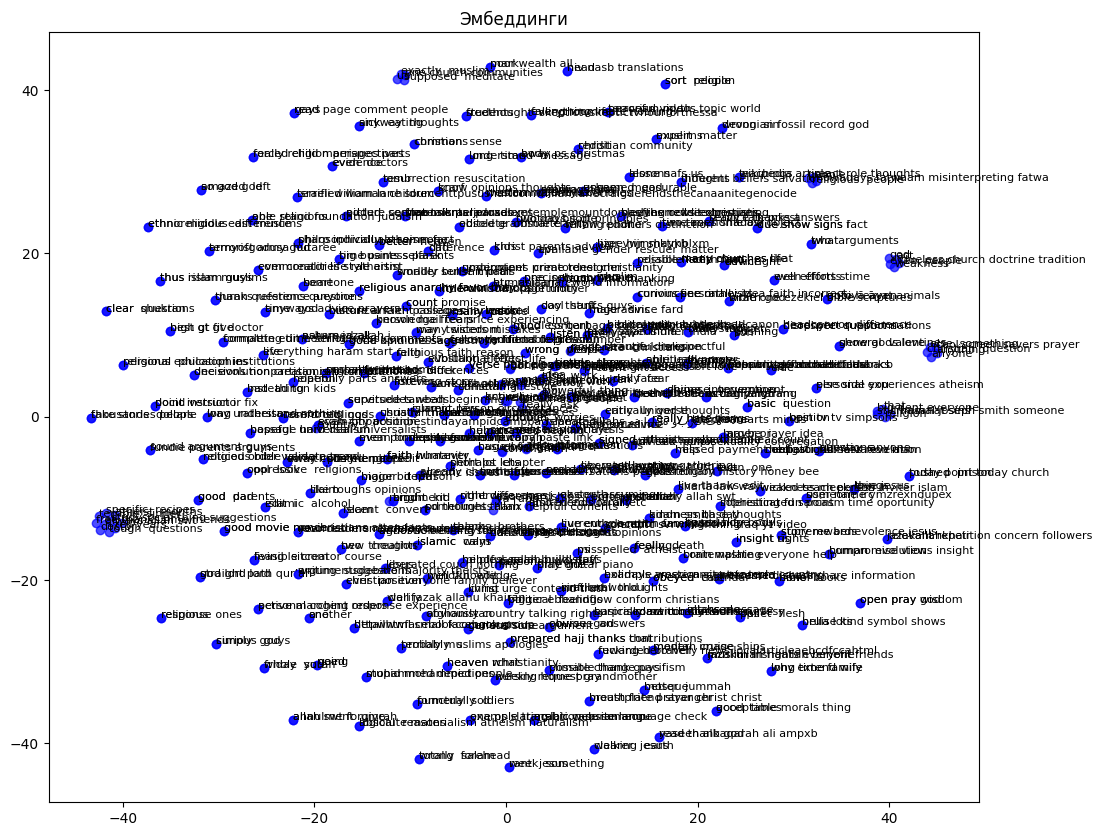

In [ ]:
embeddings = np.array([model.wv[node] for node in G.nodes()])
tsne = TSNE(n_components=2, perplexity=10, n_iter=400)
embeddings_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)
for i, node in enumerate(G.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)
    plt.title('Эмбеддинги')
plt.show()

In [ ]:
embeddings_2d

array([[-15.683466  ,  10.159202  ],
       [-15.68155   ,  10.160992  ],
       [  0.98741597, -16.572916  ],
       ...,
       [ -7.866638  , -44.209232  ],
       [ 24.422472  ,   5.260564  ],
       [ 24.423304  ,   5.2603283 ]], dtype=float32)

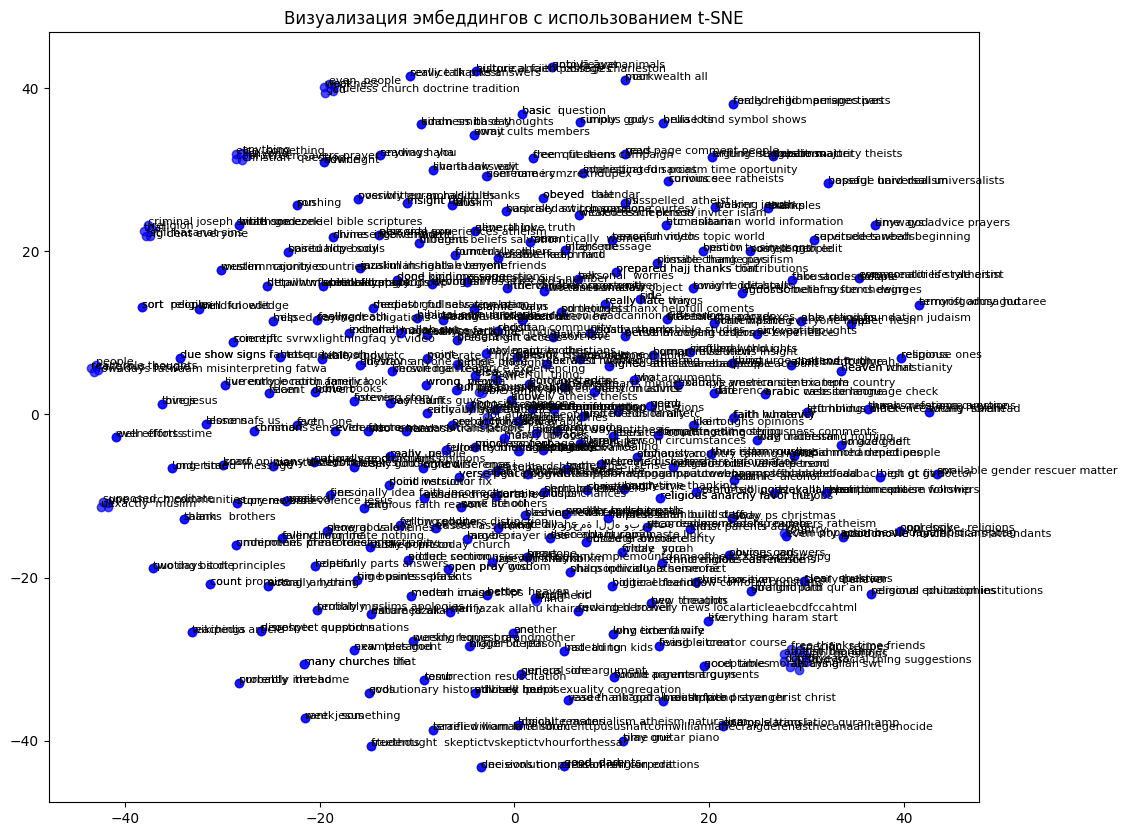

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Получение эмбеддингов узлов
embeddings = np.array([model.wv[node] for node in G.nodes()])

# Применение t-SNE для снижения размерности до 2
tsne = TSNE(n_components=2, perplexity=10, n_iter=400)
embeddings_2d = tsne.fit_transform(embeddings)

# Визуализация
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)

# Добавление подписей к точкам
for i, node in enumerate(G.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)

# Добавление заголовка
plt.title('Визуализация эмбеддингов с использованием t-SNE')

# Отображение графика
plt.show()
